# Compare obs to ERA5 reanalysis
- CERES (from Ryan Kramer)
- OISST (from NOAA)

# CERES 
(dir: `/work/rjk/data/CERES/EBAF-All`)

In [1]:
import xarray as xr
import json
import gcsfs
import numpy as np
import cmocean
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
from scipy import stats
import matplotlib as mpl
from matplotlib.colors import TwoSlopeNorm
from scipy.stats import linregress
import jo_regress

In [7]:
ceres_ds = xr.open_dataset('/work/rjk/data/CERES/EBAF-All/CERES_EBAF_Ed4.2_Subset_200003-202312.nc', chunks={})

In [35]:
gom = dict(lat=slice(17.5,31), lon=slice(262,280), time=slice(None, '2021-06-30'))
ceres = ceres_ds.sel(**gom)

In [36]:
ceres

<xarray.Dataset> Size: 8MB
Dimensions:                (time: 256, lon: 18, lat: 14)
Coordinates:
  * time                   (time) datetime64[ns] 2kB 2000-03-15 ... 2021-06-15
  * lon                    (lon) float32 72B 262.5 263.5 264.5 ... 278.5 279.5
  * lat                    (lat) float32 56B 17.5 18.5 19.5 ... 28.5 29.5 30.5
Data variables: (12/31)
    toa_sw_all_mon         (time, lat, lon) float32 258kB dask.array<chunksize=(256, 14, 18), meta=np.ndarray>
    toa_lw_all_mon         (time, lat, lon) float32 258kB dask.array<chunksize=(256, 14, 18), meta=np.ndarray>
    toa_net_all_mon        (time, lat, lon) float32 258kB dask.array<chunksize=(256, 14, 18), meta=np.ndarray>
    toa_sw_clr_c_mon       (time, lat, lon) float32 258kB dask.array<chunksize=(256, 14, 18), meta=np.ndarray>
    toa_lw_clr_c_mon       (time, lat, lon) float32 258kB dask.array<chunksize=(256, 14, 18), meta=np.ndarray>
    toa_net_clr_c_mon      (time, lat, lon) float32 258kB dask.array<chunksize=(256, 14, 18), meta=np.ndarray>
    ...                     ...
    sfc_net_lw_all_mon     (time, lat, lon) float32 258kB dask.array<chunksize=(256, 14, 18), meta=np.ndarray>
    sfc_net_lw_clr_c_mon   (time, lat, lon) float32 258kB dask.array<chunksize=(256, 14, 18), meta=np.ndarray>
    sfc_net_lw_clr_t_mon   (time, lat, lon) float32 258kB dask.array<chunksize=(256, 14, 18), meta=np.ndarray>
    sfc_net_tot_all_mon    (time, lat, lon) float32 258kB dask.array<chunksize=(256, 14, 18), meta=np.ndarray>
    sfc_net_tot_clr_c_mon  (time, lat, lon) float32 258kB dask.array<chunksize=(256, 14, 18), meta=np.ndarray>
    sfc_net_tot_clr_t_mon  (time, lat, lon) float32 258kB dask.array<chunksize=(256, 14, 18), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.1.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.4
    institution:  NASA Langley Research Center
    title:        CERES EBAF TOA and Surface Fluxes. Monthly Averages and 07/...
    comment:      Climatology from 07/2005 to 06/2015
    version:      Edition 4.2; Revised data Release Date January 2, 2024
    DOI:          10.5067/TERRA-AQUA-NOAA20/CERES/EBAF_L3B004.2
    history:      Wed May 01 23:30:25 2024: cdo cat CERES_EBAF_Ed4.2_Subset_2...
    CDO:          Climate Data Operators version 2.1.1 (https://mpimet.mpg.de...

In [37]:
#sfc_sw_down_all - sfc_sw_up_all = sfc_net_sw_all
sw = ceres.sfc_net_sw_all_mon - ceres.toa_sw_all_mon
lw = ceres.sfc_net_lw_all_mon - ceres.toa_lw_all_mon

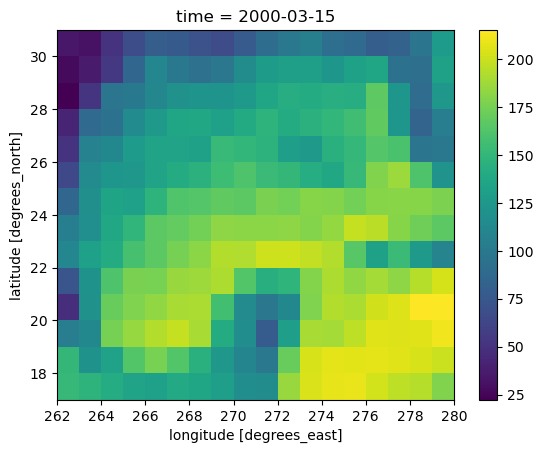

In [38]:
sw[0].plot()

In [39]:
#linear regression at every grid cell over time, so that we see trend rate at each grid pt
# Calculate the linear trend at each grid point
def trending(da):
    d = da.groupby('time.year').mean('time').polyfit('year', deg=1, skipna=True, cov=True)

    return d

In [40]:
trend_lw = trending(lw)
trend_sw = trending(sw)

In [41]:
def plot_trend(da, title, var_title, cbar_label, v_min, v_max, cmap_choice, diverge=True):
    proj = ccrs.Mercator() #with Mercator you can put lat lon values.
    fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))
    
    ax.set_extent([-98, -81, 17.5, 31], crs=ccrs.PlateCarree())
    
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor='0.5'))
    if diverge==True:
        d = da.polyfit_coefficients[0]
        norm = TwoSlopeNorm(vmin=v_min, vcenter=0, vmax=v_max)
        im = ax.pcolormesh(d.lon, d.lat, d, transform=ccrs.PlateCarree(), 
                           norm=norm, cmap=cmap_choice)
        cb = fig.colorbar(im, ax=ax, shrink=0.4)
        cb.set_label(fr"{cbar_label}", labelpad=12, fontsize=20)
        
        g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
        g1.xlabels_top = False
        g1.ylabels_right = False
        
        plt.title(f'{title}', fontsize=26);
    else:
        d = da.polyfit_coefficients[0]
        im = ax.pcolormesh(d.lon, d.lat, d, transform=ccrs.PlateCarree(), 
                           vmin=v_min, vmax=v_max, cmap=cmap_choice)#norm=LogNorm(),
        cb = fig.colorbar(im, ax=ax, shrink=0.4)
        cb.set_label(fr"{cbar_label}", labelpad=12, fontsize=20)
        
        g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
        g1.xlabels_top = False
        g1.ylabels_right = False
        
        plt.title(f'{title}', fontsize=26)
    #plt.savefig(f'/work5/stb/MHW-gfdl/paper-figs/trend_spatio_{var_title}.pdf');

In [42]:
print('Max: ', trend_lw.polyfit_coefficients[0].max().values, 'W/m2/yr', 
      '\nMin: ', trend_lw.polyfit_coefficients[0].min().values, 'W/m2/yr')

Max:  0.5469404982012692 W/m2/yr 
Min:  -0.365676785107722 W/m2/yr


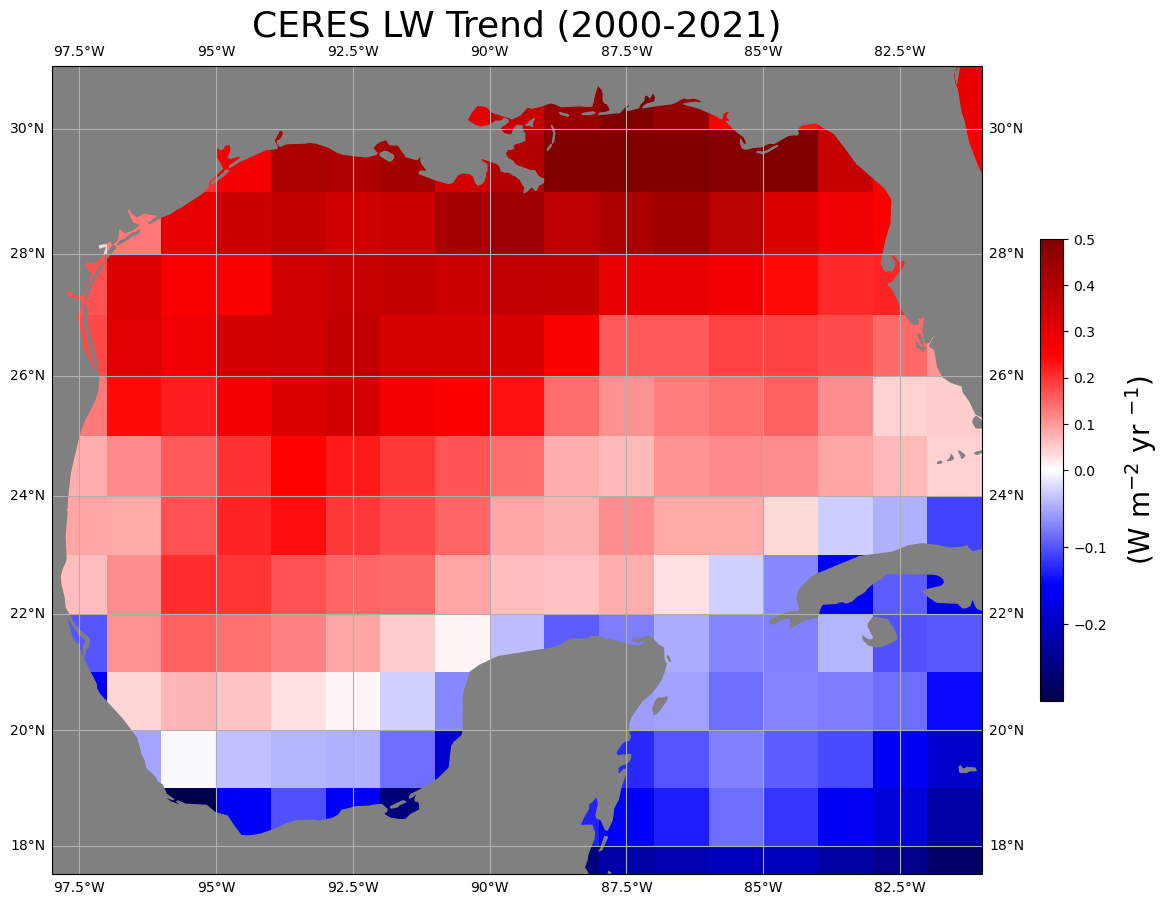

In [43]:
plot_trend(trend_lw, 'CERES LW Trend (2000-2021)', 'LW', '(W m$^{-2}$ yr $^{-1}$)', 
           -0.3, 0.5, cmap_choice='seismic')

In [44]:
print('Max: ', trend_sw.polyfit_coefficients[0].max().values, 'W/m2/yr', 
      '\nMin: ', trend_sw.polyfit_coefficients[0].min().values, 'W/m2/yr')

Max:  0.811501126582812 W/m2/yr 
Min:  -0.9422240900764515 W/m2/yr


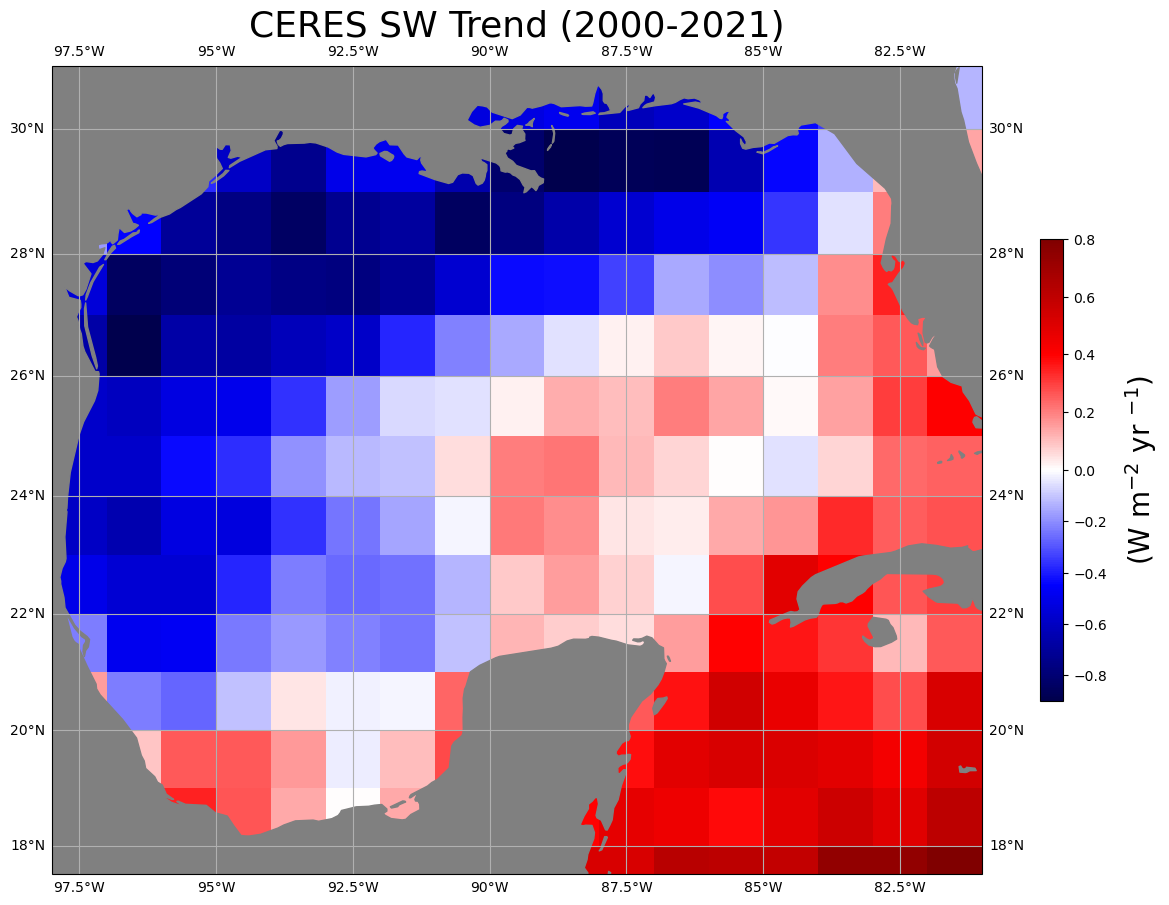

In [45]:
plot_trend(trend_sw, 'CERES SW Trend (2000-2021)', 'SW', '(W m$^{-2}$ yr $^{-1}$)', 
           -0.9, 0.8, cmap_choice='seismic')

# [OISST](https://psl.noaa.gov/data/gridded/data.noaa.oisst.v2.highres.html) 
(need to confirm if this is (AMSR)+AVHRR or just AVHRR, i think it's the former)

In [46]:
oisst_ds = xr.open_dataset('sst.mon.mean.nc', chunks={})

In [48]:
oisst = oisst_ds.sel(**gom)

In [55]:
oisst.sst

<xarray.DataArray 'sst' (time: 478, lat: 54, lon: 72)> Size: 7MB
dask.array<getitem, shape=(478, 54, 72), dtype=float32, chunksize=(1, 54, 72), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 4kB 1981-09-01 1981-10-01 ... 2021-06-01
  * lat      (lat) float32 216B 17.62 17.88 18.12 18.38 ... 30.38 30.62 30.88
  * lon      (lon) float32 288B 262.1 262.4 262.6 262.9 ... 279.4 279.6 279.9
Attributes:
    long_name:      Monthly Mean of Sea Surface Temperature
    units:          degC
    valid_range:    [-3. 45.]
    precision:      2.0
    dataset:        NOAA High-resolution Blended Analysis
    var_desc:       Sea Surface Temperature
    level_desc:     Surface
    statistic:      Monthly Mean
    parent_stat:    Individual Observations
    actual_range:   [-1.8  32.14]
    standard_name:  sea_surface_temperature

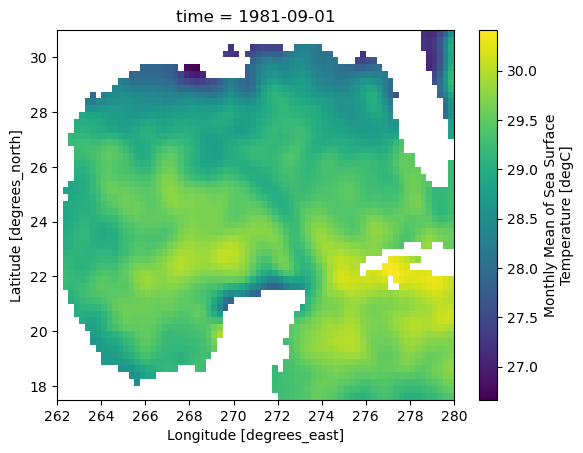

In [50]:
oisst.sst[0].plot()

In [53]:
trend_oisst = trending(oisst.sst)

In [54]:
print('Max: ', trend_oisst.polyfit_coefficients[0].max().values, '˚C/yr', 
      '\nMin: ', trend_oisst.polyfit_coefficients[0].min().values, '˚C/yr')

Max:  0.0246277526695968 ˚C/yr 
Min:  -0.04117685377805418 ˚C/yr


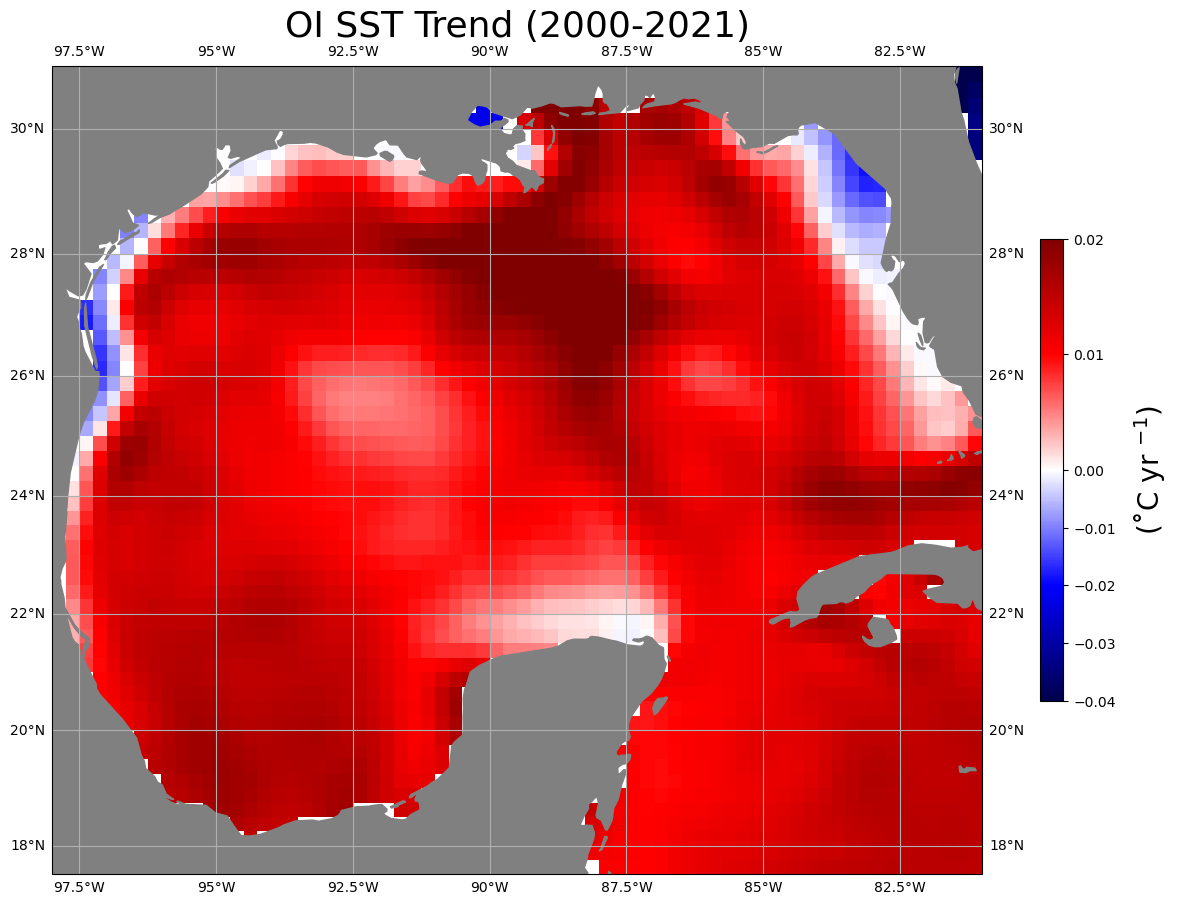

In [56]:
plot_trend(trend_oisst, 'OI SST Trend (2000-2021)', 'SW', '(˚C yr $^{-1}$)', 
           -0.04, 0.02, cmap_choice='seismic')